# Triple Junction Solar Cells

Triple junction solar cells are a type of multi-junction PV device that can exceed the Shockley-Queisser (detailed balance) limit.
It is designed to maximize efficiency by capturing and converting a broader spectrum of sunlight into electricity.

The three layers consist of
1. Top Layer (GaInP - Gallium Indium Phosphide):
GaInP has a high bandgap (~1.85 eV) and absorbs high-energy photons (primarily in the blue and green regions of the spectrum).
2. Middle Layer (GaAs - Gallium Arsenide):
GaAs has a medium bandgap (~1.42 eV) and absorbs photons in the red and near-infrared region.
3. Bottom Layer (Ge - Germanium):
Ge has a low bandgap (~0.67 eV) and absorbs photons in the infrared region.



In [18]:
import jax.numpy as jnp
import numpy as onp
import scipy.constants as scic

import matplotlib.pyplot as plt
from jaxlayerlumos.utils_units import convert_m_to_nm
from jaxlayerlumos.utils_units import convert_m_to_um

from jaxlayerlumos import stackrt
from jaxlayerlumos import utils_materials
from jaxlayerlumos import utils_spectra


from jaxlayerlumos import utils_position

from jaxlayerlumos import utils_units

Here we plot the absorption as a function of photon energy for each of the three materials. The different spectral utilization of each layer can be observed

/Users/pleu/Documents/PaulsAcademicJunk/Proposals/ARL/ARL_AR/Data/Python/JaxLayerLumos/jaxlayerlumos/utils_materials.py:118: UserWarning: Extrapolation detected: Some frequencies are outside the given data range.
  warnings.warn("Extrapolation detected: Some frequencies are outside the given data range.", UserWarning)


Text(0, 0.5, 'Absorption per Layer (eV)')

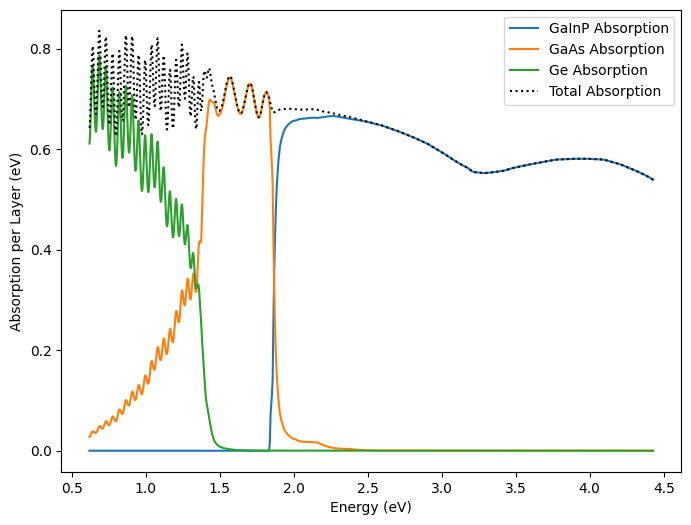

In [57]:
wavelengths = jnp.linspace(280e-9, 2000e-9, 1000)
# wavelengths = jnp.array([1000e-9])
frequencies = scic.c / wavelengths

materials = onp.array(["Air", "GaInP", "GaAs", "Ge"])
thickness_materials = [0, 1e-6, 3e-6, 0]

thicknesses = jnp.array(thickness_materials)
n_k = utils_materials.get_n_k(materials, frequencies)
theta_inc = 0
# We have to also get the coefficients back

R_TE, T_TE, R_TM, T_TM, results_coeffs = stackrt(
        n_k, thicknesses, frequencies, theta_inc, return_coeffs = True
    )

A_TE = 1 - R_TE

# this returns the absorption at each specific thickness
results_coeffs = utils_position.calc_absorption_in_each_layer(
    thicknesses, results_coeffs
)

energy = utils_spectra.convert_wavelengths_to_energy(wavelengths)
plt.figure(figsize=(8, 6))

for i in range(1, 4): # loop over 3 middle layers
    material_name = materials[i]
    plt.plot(energy, results_coeffs["absorption_layer_TE"][i,:], label=f'{material_name} Absorption')

plt.plot(energy, A_TE.flatten(), 'k:', label='Total Absorption')

plt.legend()
plt.xlabel("Energy (eV)")
plt.ylabel("Absorption per Layer (eV)")


We additionally want to see the absorption plotted as a function of position. In this case, we plot the solar absorption, which is defined as the spatially resolved absorption of incident solar radiation within each layer of the solar cell.



Text(0, 0.5, 'Absorption (1/um)')

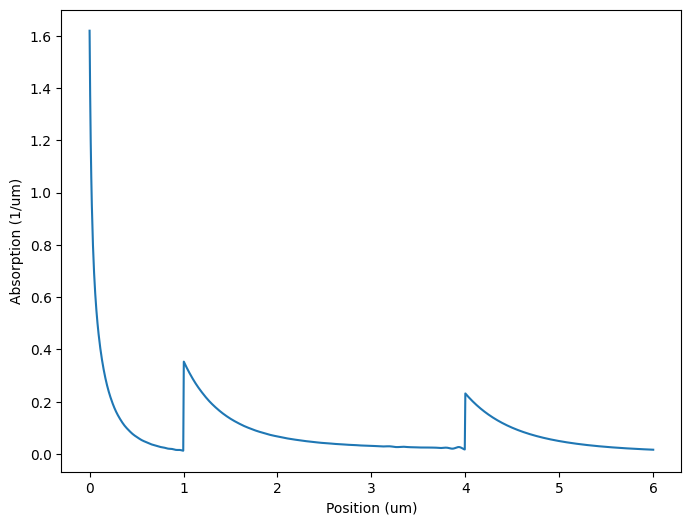

In [54]:
wavelengths_all = jnp.linspace(280e-9, 4000e-9, 2000)
wavelengths_all_nm = convert_m_to_nm(wavelengths_all)
irradiance_all = utils_spectra.get_irradiance('AM1p5G', wavelengths_all)
photon_flux_all = (irradiance_all * wavelengths_all)/(scic.h*scic.c)
total_photons = onp.trapezoid(photon_flux_all, wavelengths_all_nm)

theta_inc = 0

wavelengths = jnp.linspace(280e-9, 2000e-9, 1000)
# wavelengths = jnp.array([1000e-9])
frequencies = scic.c / wavelengths
irradiance = utils_spectra.get_irradiance('AM1p5G', wavelengths)
photon_flux = (irradiance * wavelengths)/(scic.h*scic.c)
energy = utils_units.get_light_speed()* scic.h/ wavelengths/scic.e
wavelengths_nm = convert_m_to_nm(wavelengths)

R_TE, T_TE, R_TM, T_TM, results_coeffs = stackrt(
        n_k, thicknesses, frequencies, theta_inc, return_coeffs = True
    )

position = onp.linspace(0, sum(thickness_materials)*1.5, 1000)
layer, position_in_layer = utils_position.calc_position_in_structure(
    thickness_materials, position
)

results_coeffs = utils_position.calc_position_data(
    layer, position_in_layer, results_coeffs
)

absorption_location = onp.trapezoid(results_coeffs['absorb_TE'][0]*photon_flux[:, onp.newaxis], wavelengths_nm, axis = 0 )/total_photons*scic.micro # convert from absorption/meter to absorption/micron

plt.figure(figsize=(8, 6))
plt.plot(convert_m_to_um(position), absorption_location)

plt.xlabel("Position (um)")
plt.ylabel("Absorption (1/um)")
# plt.ylim([0, 1e3])


We can also plot the absorption or Poynting vector at specific wavelengths, which show that different wavelengths are absorbed in the front layer, second layer, or third layer.

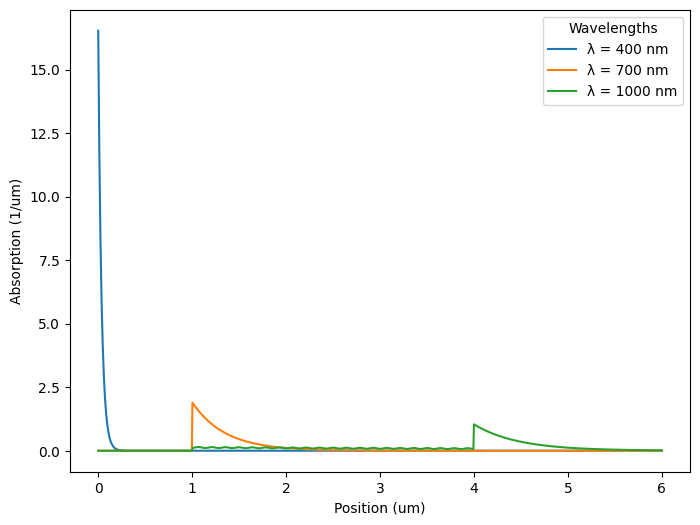

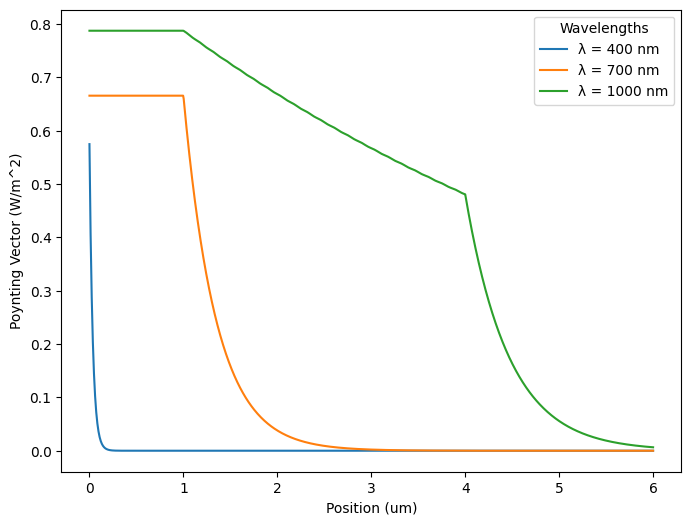

In [113]:
wavelengths = jnp.array([400e-9, 700e-9, 1000e-9])
frequencies = scic.c / wavelengths

theta_inc = 0

n_k = utils_materials.get_n_k(materials, frequencies)


R_TE, T_TE, R_TM, T_TM, results_coeffs = stackrt(
        n_k, thicknesses, frequencies, theta_inc, return_coeffs = True
    )

position = onp.linspace(0, sum(thickness_materials)*1.5, 1000)
layer, position_in_layer = utils_position.calc_position_in_structure(
    thickness_materials, position
)

results_coeffs = utils_position.calc_position_data(
    layer, position_in_layer, results_coeffs
)

plt.figure(figsize=(8, 6))

absorb_TE_data = results_coeffs['absorb_TE'][0, :, :].T / 1e6

for i, wavelength in enumerate(wavelengths):
    plt.plot(convert_m_to_um(position), absorb_TE_data[:, i], label=f'λ = {wavelength * 1e9:.0f} nm')

plt.xlabel("Position (um)")
plt.ylabel("Absorption (1/um)")
plt.legend(title = "Wavelengths")

plt.figure(figsize=(8, 6))

poynting = results_coeffs['poyn_TE'][0, :, :].T
for i, wavelength in enumerate(wavelengths):
    plt.plot(convert_m_to_um(position), poynting[:, i], label=f'λ = {wavelength * 1e9:.0f} nm')

plt.xlabel("Position (um)")
plt.ylabel("Poynting Vector Magnitude (W/m^2)")
plt.legend(title = "Wavelengths")



In [99]:
absorption_vs_position.shape

AttributeError: 'function' object has no attribute 'shape'